In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# retrieve data
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# drop missing values
df = df.dropna()

# rename columns for clarification
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

# only pick locations around Melbourne
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]

In [4]:
# map dates to the four seasons of the year (for more equal data points to learn from)
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'
    
# use date_to_seasons function to transform dates to seasons
df["Date"] = pd.to_datetime(df["Date"])
df["Season"] = df["Date"].apply(date_to_season)
df = df.drop(columns = "Date")

In [5]:
# input and target data
X = df.drop(columns = "Rainfall", axis = 1)
y = df["Rainfall"]

In [6]:
# transform "Rainfall" from continuous to binary
y = y.where(y == 0.0, other = 1).astype(int)

In [7]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [8]:
# split features into numeric and categorical, to apply OneHotEncoding and StandardScaler respectively
numeric_features = X_train.select_dtypes(include = ["float64"]).columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_features = X_train.select_dtypes(include = ["object","category"]).columns.tolist()
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [9]:
# merge data again
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [10]:
# create pipeline
pipeline = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
    ]
)

In [11]:
# define parameters for GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [12]:
# crossvalidation method to avoid data snooping
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [13]:
# define gridsearch
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring="accuracy", verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pressure3pm',...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'RainToday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85
Test set score: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       891
           1       0.92      0.67      0.78       621

    accuracy                           0.84      1512
   macro avg       0.86      0.82      0.83      1512
weighted avg       0.85      0.84      0.84      1512



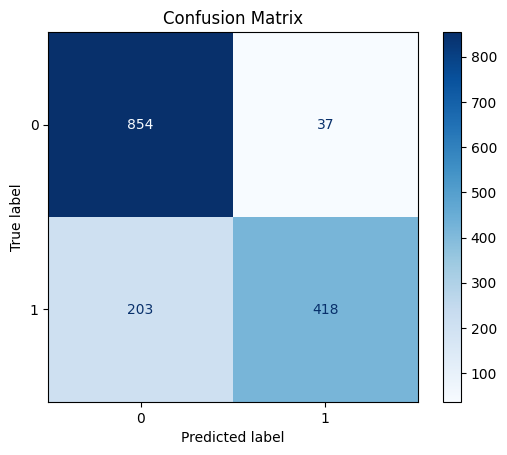

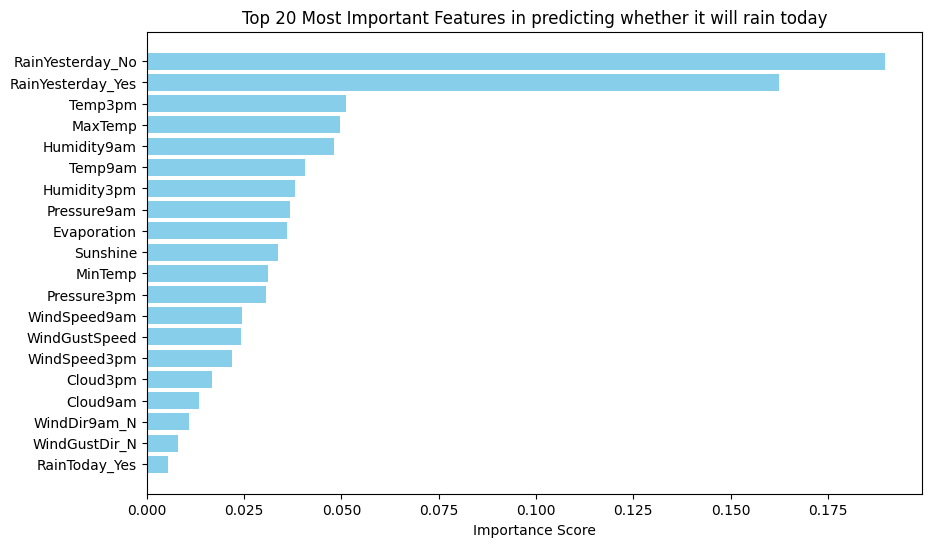

In [14]:
# print performance of RandomForestClassifier
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [15]:
# train the model again, but with Logistic Regression this time

# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No


Best parameters found:  {'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.84
Test set score: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       891
           1       0.90      0.67      0.77       621

    accuracy                           0.84      1512
   macro avg       0.85      0.81      0.82      1512
weighted avg       0.85      0.84      0.83      1512



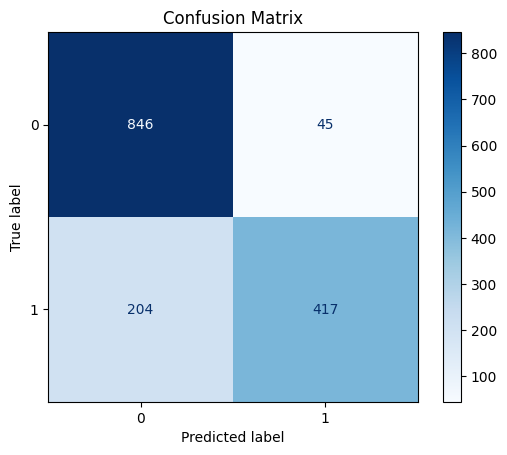

In [17]:
# print performance of Logistic Regression
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

y_pred = grid_search.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()